## Getting SHAP Values

In [1]:

from transformers import BioGptTokenizer, BioGptModel  # reads the local_transformers folder instead of the actual transformers package
import torch
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import shap
import pickle
import matplotlib.pyplot as plt
from matplotlib.image import imread
from torch.utils.data import Dataset, DataLoader
df=pd.read_csv("df.csv")
## Part I: Death_in_30_outcome_fold_1
import shap
import torch
import xgboost as xgb
import numpy as np
import cupy as cp

# Load pre-trained model and tokenizer
tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt",use_fast=True)

class WrapperModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input):
        outputs = self.model(input)
        embeddings=outputs.hidden_states[-1]
        #embeddings = outputs.last_hidden_state
        pooled_embeddings = embeddings.mean(dim=1)
        return pooled_embeddings

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def batched_process(model, data, batch_size=64):
    dataset = TextDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    output = []
    for batch in dataloader:
        batch = [item for item in batch]
        with torch.no_grad():
            batch_out = model(
                torch.tensor(
                    [tokenizer.encode(v, padding='max_length', max_length=64, truncation=True) for v in batch]
                ).to('cuda')
            )
            batch_out_np = batch_out.cpu().numpy()  # Convert tensor to numpy array
            output.append(batch_out_np)
    return np.concatenate(output, axis=0)

def save_shap_values(filename, shap_values):
    # Create a tuple of the values, base_values, data, and feature names
    data_to_save = (shap_values.values, shap_values.base_values, shap_values.data, shap_values.feature_names)
    # Save the tuple using pickle
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)

def load_shap_values(filename):
    # Load the saved tuple
    with open(filename, 'rb') as f:
        values, base_values, data, feature_names = pickle.load(f)
    # Reconstruct the Explanation object
    loaded_shap_values = shap.Explanation(values, base_values, data)
    # Assign the loaded feature names
    loaded_shap_values.feature_names = feature_names
    return loaded_shap_values


model = BioGptModel.from_pretrained("cja5553/BJH-perioperative-notes-bioGPT",
                                  use_auth_token="<enter user token>").cuda()
# Wrap the model
wrapped_model = WrapperModel(model)
# Processing data in batches
X_embed = batched_process(wrapped_model, list(df["AN_PROC_NAME"]))

C:\Users\charl\anaconda3\envs\pytorch_env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\charl\anaconda3\envs\pytorch_env\lib\site-packages\transformers\modeling_utils.py:3220: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [1]:
y = df["death_in_30"].values
# Fit the XGBoost model
xg_model=xgb.XGBClassifier(device = "cuda",learning_rate=0.1, max_depth=4, min_child_weight=2)
xg_model.fit(cp.array(X_embed),cp.array(y))
def fn(texts):
    embeds=batched_process(wrapped_model, texts)
    return xg_model.predict_proba(cp.array(embeds))
# shap_values = explainer(list(df["AN_PROC_NAME"]))
masker = shap.maskers.Text(tokenizer, mask_token = "<mask>", collapse_mask_token=True)
# Now use the wrapped_model, the tokenizer, and the masker in the shap explainer
explainer = shap.Explainer(fn, masker)
shap_values=explainer(list(df["AN_PROC_NAME"]))
# # Save the shap_values
save_shap_values('death_in_30_shap_pretrained.pickle', shap_values)

In [ ]:
# shap.plots.bar(shap_values[:, :, 1].mean(0))

## Plotting

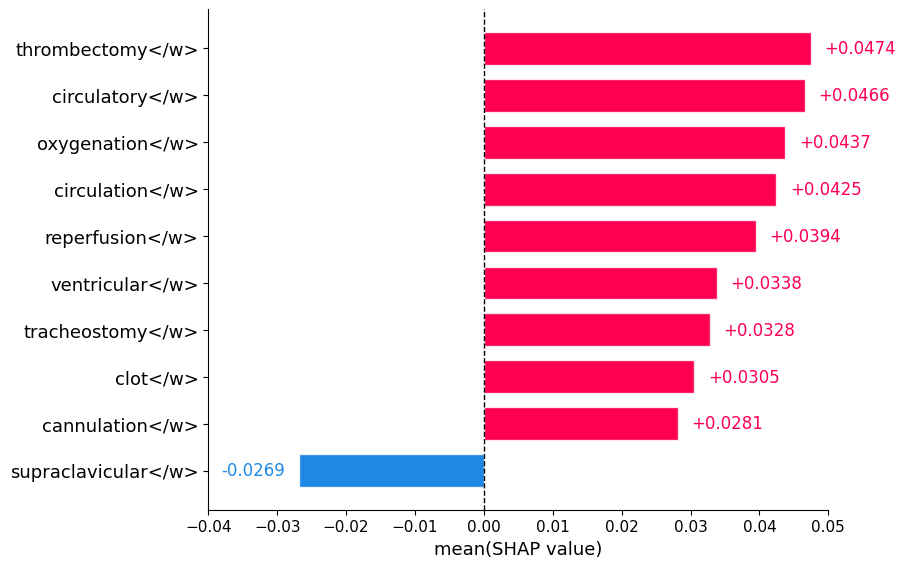

In [3]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Save a reference to the original bar function
original_bar = shap.plots.bar

# Override the function
def custom_bar(
    shap_values,
    max_display=10,
    order=shap.Explanation.abs,
    clustering=None,
    clustering_cutoff=0.5,
    show_data="auto",
    ax=None,
    show=True,
):
    """
    Custom version of shap.plots.bar that removes the 'Sum of XXX other features' bar
    and matches the SHAP original plot style, including value annotations.
    """
    from shap.utils import format_value

    # Handle SHAP values as Explanation objects or numpy arrays
    if isinstance(shap_values, shap.Explanation):
        values = shap_values.values
        feature_names = shap_values.feature_names
    else:
        values = shap_values
        feature_names = [f"Feature {i}" for i in range(len(values))]

    # Sort features by importance
    feature_order = np.argsort(-np.abs(values))
    feature_inds = feature_order[:max_display]  # Top features only

    # Build labels for the top features only
    y_pos = np.arange(1, len(feature_inds) + 1)
    yticklabels = [feature_names[i] for i in feature_inds]

    # Set SHAP colors (positive and negative values)
    bar_colors = ["#FF0051" if v > 0 else "#1E88E5" for v in values[feature_inds]]

    # Plot the bars for the top features
    if ax is None:
        fig, ax = plt.subplots()
        row_height = 0.5
        fig.set_size_inches(8, len(feature_inds) * row_height + 1.5)

    bars = ax.barh(
        y_pos,
        values[feature_inds],
        height=0.7,
        color=bar_colors,
        edgecolor=(1, 1, 1, 0.8),  # Add white edge styling like SHAP
    )

    # Add value annotations at the ends of the bars
    for bar, value in zip(bars, values[feature_inds]):
        # Adjust annotation position for positive/negative values
        x_position = bar.get_x() + bar.get_width() + (0.002 if value > 0 else -0.002)
        alignment = "left" if value > 0 else "right"
        ax.text(
            x_position,
            bar.get_y() + bar.get_height() / 2,
            f"{value:+.4f}",  # Format values with + for positive
            va="center",
            ha=alignment,
            fontsize=12,
            color="#FF0051" if value > 0 else "#1E88E5",
        )

    # Set the y-tick labels and axis properties
    ax.set_yticks(y_pos)
    ax.set_yticklabels(yticklabels, fontsize=13)
    ax.invert_yaxis()  # Highest SHAP value on top
    ax.axvline(0, color="black", linestyle="--", linewidth=1)  # Zero line

    # Set axis labels
    ax.set_xlabel("mean(SHAP value)", fontsize=13)
    ax.tick_params("x", labelsize=11)

    # Remove unnecessary spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(left=-0.04, right=0.05)
    # Show the plot
    if show:
        plt.show()
    else:
        return ax

# Monkey-patch the SHAP bar function
shap.plots.bar = custom_bar



shap.plots.bar(shap_values[:, :, 1].mean(0), max_display=10)
